# Introduction

**Description**
Our team is currently developing a new platform that brings AI capabilities to all JetBrains products. Part of this platform is based on compact and efficient language models which help users write better text, no matter what JetBrains product they are using. We are looking for an ML Engineer who can contribute to our grammar error correction service within our writing assistance project. There are several open ideas which we would potentially like to explore:

* Fine-tuning large language models for the grammar error correction tasks
* Experimenting with ensembling and ranking of single-model systems
* Adapting recent advances in text-editing to grammar error correction
* Augmenting and enhancing our datasets using LLMs or alternative methods

Of course, we also welcome your own ideas and the application of other research papers.

**Test task 2**
One of the most widespread applications of natural language processing is to correct erroneous texts, in particular incorrectly spelled words. ***Your goal is to explore the existing spell checking tools and evaluate them***.

We suggest the following steps for this test assignment:

* Collect the data for evaluation, e.g. you can use publicly available datasets, generate synthetic data, combine different approaches – it's up to you.
* Research and choose the metrics you want to use for evaluation.
* Explore the existing spell checkers (e.g. libraries, fine-tuned models, LLMs), pick some you like and evaluate them on the created test set.
* Analyse the results and think about the strengths and weaknesses of each spell checker, as well as the reasons for that. Think about how they could be improved.

As a result, you should provide a link to a repository containing the source code and documentation, e.g.:

* Scripts containing data preparation and evaluation
* Documentation describing datasets, tools and metrics you used
* A short report that describes your approach and ideas summarises the results and discusses the challenges you encountered
* Instructions on how to run and locally reproduce the results

# Setup

In [1]:
import multiprocessing

multiprocessing.cpu_count()

4

In [2]:
%%capture
!pip install transformers==4.44.2 swifter==1.4.0 seaborn==0.13.1 nltk==3.8.1 python-Levenshtein==0.25.1 errant spacy nlpaug 
!pip install boto3 --upgrade

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Prepare the dataset

In [4]:
# links https://huggingface.co/datasets/jhu-clsp/jfleg
# https://www.kaggle.com/datasets/satishgunjal/grammar-correction/data
# https://www.kaggle.com/code/dariocioni/gec-with-transformers-from-scratch
# https://github.com/mhagiwara/github-typo-corpus?tab=readme-ov-file

In [5]:
#!git clone https://github.com/Sopralapanca/jet-brains-internship-challenge

In [6]:
from datasets import load_dataset
import pandas as pd

ds = load_dataset("abisee/cnn_dailymail", "1.0.0")
df = ds['train'].to_pandas()

pd.set_option('display.max_colwidth', None)
df.head(2)

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in ""Harry Potter and the Order of the Phoenix"" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. ""I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar,"" he told an Australian interviewer earlier this month. ""I don't think I'll be particularly extravagant. ""The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs."" At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film ""Hostel: Part II,"" currently six places below his number one movie on the UK box office chart. Details of how he'll mark his landmark birthday are under wraps. His agent and publicist had no comment on his plans. ""I'll definitely have some sort of party,"" he said in an interview. ""Hopefully none of you will be reading about it."" Radcliffe's earnings from the first five Potter films have been held in a trust fund which he has not been able to touch. Despite his growing fame and riches, the actor says he is keeping his feet firmly on the ground. ""People are always looking to say 'kid star goes off the rails,'"" he told reporters last month. ""But I try very hard not to go that way because it would be too easy for them."" His latest outing as the boy wizard in ""Harry Potter and the Order of the Phoenix"" is breaking records on both sides of the Atlantic and he will reprise the role in the last two films. Watch I-Reporter give her review of Potter's latest » . There is life beyond Potter, however. The Londoner has filmed a TV movie called ""My Boy Jack,"" about author Rudyard Kipling and his son, due for release later this year. He will also appear in ""December Boys,"" an Australian film about four boys who escape an orphanage. Earlier this year, he made his stage debut playing a tortured teenager in Peter Shaffer's ""Equus."" Meanwhile, he is braced for even closer media scrutiny now that he's legally an adult: ""I just think I'm going to be more sort of fair game,"" he told Reuters. E-mail to a friend . Copyright 2007 Reuters. All rights reserved.This material may not be published, broadcast, rewritten, or redistributed.",Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday . Young actor says he has no plans to fritter his cash away . Radcliffe's earnings from first five Potter films have been held in trust fund .,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,"Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the ""forgotten floor,"" where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the ""forgotten floor."" Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually ""avoidable felonies."" He says the arrests often result from confrontations with police. Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely to follow directions, according to Leifman. So, they end up on the ninth floor severely mentally disturbed, but not getting any real help because they're in jail. W

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287113 entries, 0 to 287112
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   article     287113 non-null  object
 1   highlights  287113 non-null  object
 2   id          287113 non-null  object
dtypes: object(3)
memory usage: 6.6+ MB


In [8]:
# consider only "highlights" column to obtain the sentences and reduce the dataframe only to 2000 examples
n_samples = 2000
df_short = df.sample(n_samples, random_state=42)
df_short = df_short[['highlights']]
df_short.rename(columns={"highlights": "corrections"}, inplace=True)
df_short.head()

,corrections
272581,2004 BL86 will pass about three times the distance of Earth to the moon . Estimate that the asteroid is about a third of a mile (0.5 kilometers) in size . Nasa says it poses no threat to Earth 'for the foreseeable future'
772,"Iraqi Islamic Party calls Quran incident ""blatant assault"" on Muslim holy book . U.S. soldier used Quran for target practice, military investigation found . U.S. commander in Baghdad has issued formal apology . Soldier relieved of duty, will be reassigned after sending letter of apology ."
171868,Carroll takes to Instagram to post selfie ahead of ankle surgery . West Ham star expected to be out for up to four months . The forward has had an injury-ravaged spell since moving from Liverpool .
63167,"Pop stars from all over Europe are setting their sights on the U.S. market . Estonia's Kerli, Italy's Marco Bosco and Austria's Fawni want to make it big in L.A. Los Angeles has long been a destination for European artists seeking fame ."
68522,"NEW: Young athletes light the Olympic cauldron after the queen opens the games . Performances pay tribute to British history, literature and music . The Greek delegation leads the parade of athletes into the stadium . Organizers had sought beforehand to keep the event's details secret ."


In [9]:
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import swifter
import random

# Spelling error augmenter
spelling_aug = naw.SpellingAug()

# Synonym substitution augmenter (could introduce grammatical errors when wrong synonym is selected)
synonym_aug = naw.SynonymAug(aug_max=2)

# Random word insertion augmenter
random_word_aug = naw.RandomWordAug(aug_max=2, action="swap")

# Introduce typos (character level)
typo_aug = nac.KeyboardAug(aug_char_max=2, aug_word_max=2)
    
    
def generate_errors(sentence: str):
    """
    
    param: sentence: str for grammatical sentence
    return: 
    """

    # Choose a random augmentation technique
    aug_type = random.choice(["spelling", "synonym", "insertion", "typo"])

    if aug_type == "spelling":
        ungrammatical_sentence = spelling_aug.augment(sentence)
        error_type = "spelling error"
        
    elif aug_type == "synonym":
        ungrammatical_sentence = synonym_aug.augment(sentence)
        error_type = "word substitution error"
    
    elif aug_type == "insertion":
        ungrammatical_sentence = random_word_aug.augment(sentence)
        error_type = "word insertion error"
    
    elif aug_type == "typo":
        ungrammatical_sentence = typo_aug.augment(sentence)
        error_type = "typo"

    return ungrammatical_sentence[0], error_type

# Apply the model to each sentence and store the correction in new columns
df_short[['sentence', 'error_type']] = pd.DataFrame(df_short.swifter.apply(
    lambda row: generate_errors(row['corrections']), axis=1).tolist(), index=df_short.index)
df_short.head()

2024-09-20 16:57:40,683	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Pandas Apply:   0%|          | 0/2000 [00:00<?, ?it/s]

,corrections,sentence,error_type
272581,2004 BL86 will pass about three times the distance of Earth to the moon . Estimate that the asteroid is about a third of a mile (0.5 kilometers) in size . Nasa says it poses no threat to Earth 'for the foreseeable future',2004 BL86 will pass about three times the distQnSe of Earth to the moon. Estimate that the asteroid is about a third of a mile (0. 5 kilometers) in size. Nasa says it poses no 4Jreat to Earth ' for the foreseeable future ',typo
772,"Iraqi Islamic Party calls Quran incident ""blatant assault"" on Muslim holy book . U.S. soldier used Quran for target practice, military investigation found . U.S. commander in Baghdad has issued formal apology . Soldier relieved of duty, will be reassigned after sending letter of apology .","Iraqi Islamic Party calls qran incident "" blatant assault "" on mulism holy book. You. S. soilder used Quran for target pracite, military investigation founf. U. S. commander in Baghdad is issued formal applogy. Soldier relieved of duty, will ne reassigned after seding letter of apology.",spelling error
171868,Carroll takes to Instagram to post selfie ahead of ankle surgery . West Ham star expected to be out for up to four months . The forward has had an injury-ravaged spell since moving from Liverpool .,Carroll takes to Instagram post to selfie ahead of surgery ankle. West Ham star expected to be out for up to four months. The forward has had an injury - ravaged spell since moving from Liverpool.,word insertion error
63167,"Pop stars from all over Europe are setting their sights on the U.S. market . Estonia's Kerli, Italy's Marco Bosco and Austria's Fawni want to make it big in L.A. Los Angeles has long been a destination for European artists seeking fame .","Pop stars from all over Europe are setting their sights on the U. S. market. Estonia ' s Kerli, Italy ' s Marco Bosco and Austria ' s Fawni want to mZ<e it big in L. A. Los Angeles has p0ng been a destination for European artists seeking fame.",typo
68522,"NEW: Young athletes light the Olympic cauldron after the queen opens the games . Performances pay tribute to British history, literature and music . The Greek delegation leads the parade of athletes into the stadium . Organizers had sought beforehand to keep the event's details secret .","NEW: Young athletes light the Olympic cauldron after the queen *)ens the games. Performances pay fdibute to British history, literature and music. The Greek delegation leads the parade of athletes into the stadium. Organizers had sought beforehand to keep the event ' s details secret.",typo


In [10]:
df = df_short

In [11]:
# import pandas as pd

# splits = {'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
# df_valid = pd.read_parquet("hf://datasets/jhu-clsp/jfleg/" + splits["validation"])
# df_test = pd.read_parquet("hf://datasets/jhu-clsp/jfleg/" + splits["test"])
# df = pd.concat([df_valid, df_test])

# #optionally add other senteces from other dataframes or generate sintetic data

In [12]:
# df.head()

NOTE

una analisi potrebbe essere fatta su quali sono gli errori grammaticali più comuni? se abbreviazioni, capital case, errori nei verbi, typo ecc

In [13]:
len(df)

2000

In [14]:
# df = df.explode("corrections")
# # len(df)

In [15]:
df = df.drop_duplicates(subset=["sentence", "corrections"])
len(df)

2000

In [16]:
missing_values = df.isnull().sum()
missing_values

corrections    0
sentence       0
error_type     0
dtype: int64

In [17]:
df["sentence"] = df["sentence"].str.strip()
df["corrections"] = df["corrections"].str.strip()

In [18]:
df["sentence"] = df["sentence"].str.replace(r'^\d+\.\s+', '', regex=True)
df["corrections"] = df["corrections"].str.replace(r'^\d+\.\s+', '', regex=True)

# after analyzing the dataset 'corrections' have white spaces before commas and dots. Model predictions instead write the sentences without putting white spaces between the dots.
# Preprocess the dataset such that to remove white spaces before the dots

# Remove whitespace before commas and periods in both columns
df['corrections'] = df['corrections'].str.replace(r'\s+([,.])', r'\1', regex=True)


In [19]:
df.head(10)

,corrections,sentence,error_type
272581,2004 BL86 will pass about three times the distance of Earth to the moon. Estimate that the asteroid is about a third of a mile (0.5 kilometers) in size. Nasa says it poses no threat to Earth 'for the foreseeable future',2004 BL86 will pass about three times the distQnSe of Earth to the moon. Estimate that the asteroid is about a third of a mile (0. 5 kilometers) in size. Nasa says it poses no 4Jreat to Earth ' for the foreseeable future ',typo
772,"Iraqi Islamic Party calls Quran incident ""blatant assault"" on Muslim holy book. U.S. soldier used Quran for target practice, military investigation found. U.S. commander in Baghdad has issued formal apology. Soldier relieved of duty, will be reassigned after sending letter of apology.","Iraqi Islamic Party calls qran incident "" blatant assault "" on mulism holy book. You. S. soilder used Quran for target pracite, military investigation founf. U. S. commander in Baghdad is issued formal applogy. Soldier relieved of duty, will ne reassigned after seding letter of apology.",spelling error
171868,Carroll takes to Instagram to post selfie ahead of ankle surgery. West Ham star expected to be out for up to four months. The forward has had an injury-ravaged spell since moving from Liverpool.,Carroll takes to Instagram post to selfie ahead of surgery ankle. West Ham star expected to be out for up to four months. The forward has had an injury - ravaged spell since moving from Liverpool.,word insertion error
63167,"Pop stars from all over Europe are setting their sights on the U.S. market. Estonia's Kerli, Italy's Marco Bosco and Austria's Fawni want to make it big in L.A. Los Angeles has long been a destination for European artists seeking fame.","Pop stars from all over Europe are setting their sights on the U. S. market. Estonia ' s Kerli, Italy ' s Marco Bosco and Austria ' s Fawni want to mZ<e it big in L. A. Los Angeles has p0ng been a destination for European artists seeking fame.",typo
68522,"NEW: Young athletes light the Olympic cauldron after the queen opens the games. Performances pay tribute to British history, literature and music. The Greek delegation leads the parade of athletes into the stadium. Organizers had sought beforehand to keep the event's details secret.","NEW: Young athletes light the Olympic cauldron after the queen *)ens the games. Performances pay fdibute to British history, literature and music. The Greek delegation leads the parade of athletes into the stadium. Organizers had sought beforehand to keep the event ' s details secret.",typo
81888,Suliman Mohamed accused of being part of a terror plot in Canada. Canada's national security team said his arrest is directly linked to the arrests of twin brothers last week.,Suliman Mohamed accused of being part of a terror plot in Canada. Canada ' s national security team said his arrest is directly linked to the apprehension of twin brothers last week.,word substitution error
64374,"""He has brought shame on our family,"" says suspect's sister. ""I don't consider Atta Ullah my brother any more,"" she adds. The 23-year-old student is being sought in connection with the attack on Malala.",""" He has brought shame on our family, "" says suslWct ' s sister. "" I don ' t consider Atta Ullah my brother any more, "" she adds. The 23 - year - old student is being sought in connection with the a4taFk on Malala.",typo
3425,"Tsvangirai: ""It was an accident that took her life"" PM returned home from Botswana and addressed mourners at his residence. Much speculation the wreck was caused by his political opponents. Former U.S. ambassador to Zimbabwe said the wreck raised suspicion.","Tsvangirai: "" It was na accidence that took her life "" PM returend hom from Botswana and addressed mourners et this residence. Much speculation the wreck was caused by his political opponents. Former U. s. ambassad to Zimbabve said the wreck raised suspition.",spelling error
74122,"Lourdes signals intelligence

In [20]:
# get all the rows where sentence is ""

df_temp = df[df["sentence"] == ""]
len(df_temp)

0

In [21]:
# delete rows from df where sentence is ""
print(len(df))
df = df[df["sentence"] != ""]
len(df)

2000


2000

# Data Analysis

In [22]:
import matplotlib.pyplot as plt

Visualization of the sentence lengths

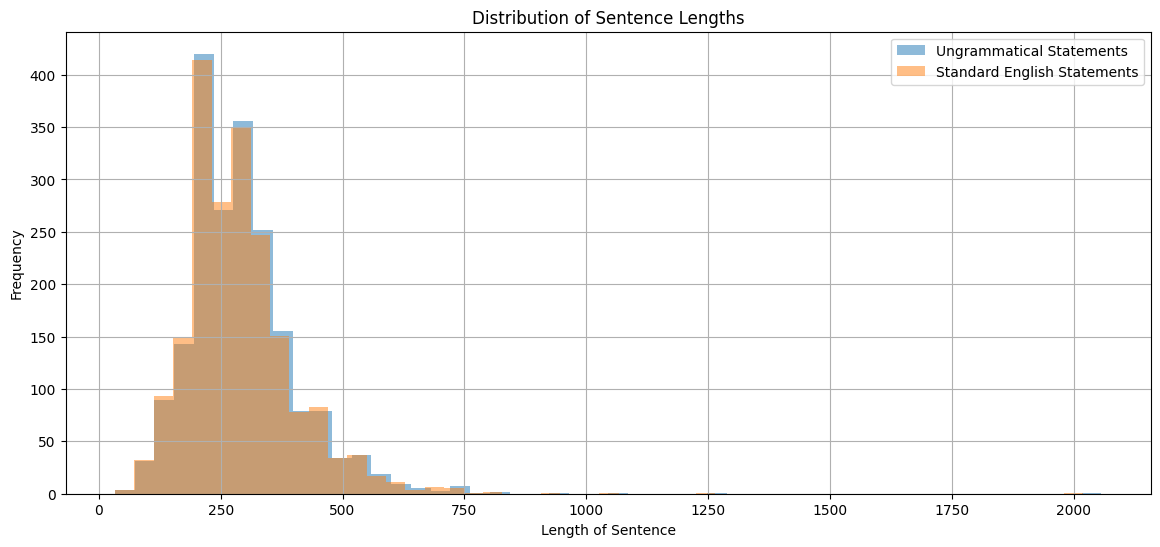

In [23]:
def plot_sentence_length_distribution(sentences: pd.Series, corrections: pd.Series):
  """
  Plot the distribution of sentence lengths for grammatical and non-grammatical sentences.
  param: sentences: pd.Series for ungrammatical sentences
  param: corrections: pd.Series for grammatical sentences
  """

  plt.figure(figsize=(14, 6))
  plt.hist(sentences.str.len(), bins=50, alpha=0.5, label='Ungrammatical Statements')
  plt.hist(corrections.str.len(), bins=50, alpha=0.5, label='Standard English Statements')
  plt.title('Distribution of Sentence Lengths')
  plt.xlabel('Length of Sentence')
  plt.ylabel('Frequency')
  plt.legend()
  plt.grid(True)

  plt.show()

plot_sentence_length_distribution(df["sentence"], df["corrections"])

Word Frequency Analysis

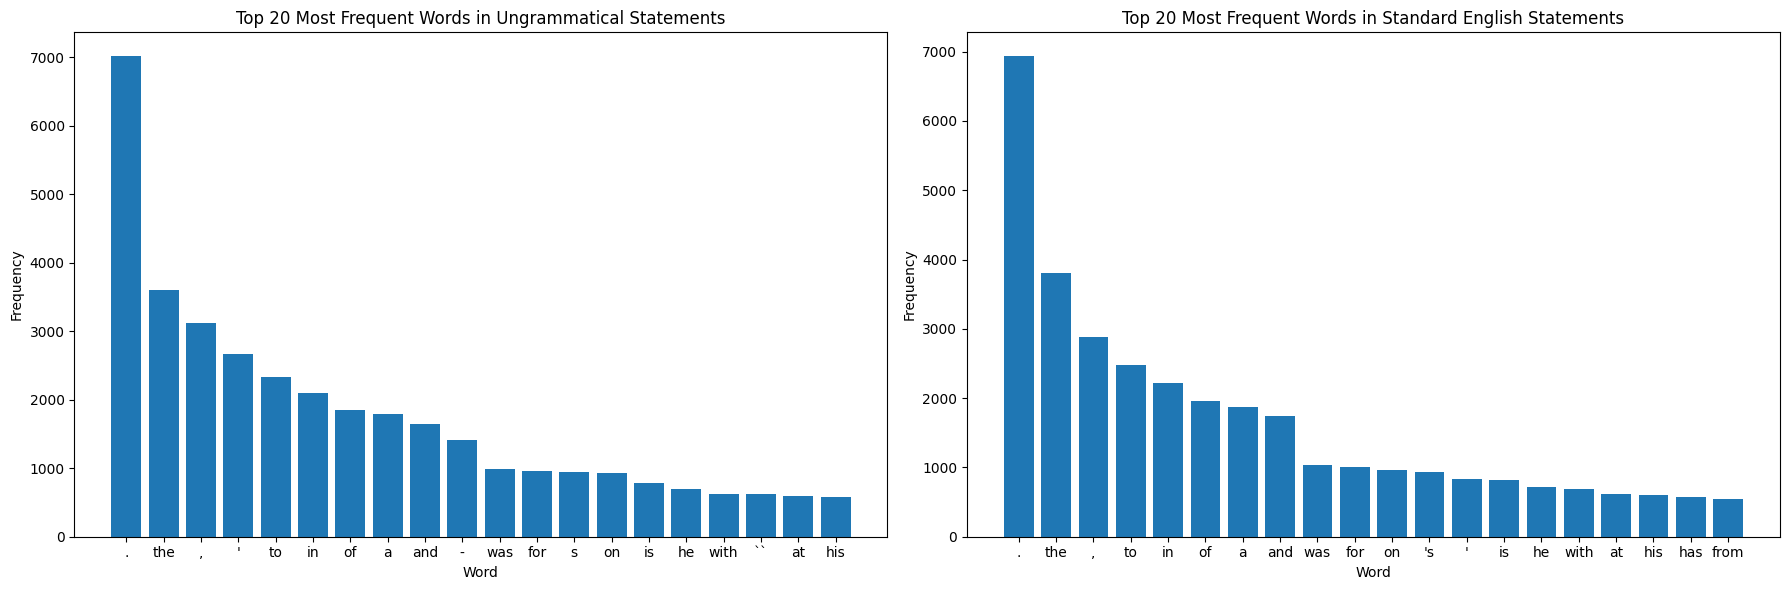

In [24]:
from collections import Counter
from nltk.tokenize import word_tokenize


def word_frequency(sentences: pd.Series, corrections: pd.Series):

    # Method to compute word frequency of a series of strings
    def compute_word_frequency(texts):
      words = []
      for text in texts:
        words.extend(word_tokenize(text.lower()))
      return Counter(words)

    # Compute word frequency for ungrammatical and grammatical sentences
    ungrammatical_word_freq = compute_word_frequency(sentences)
    grammatical_word_freq = compute_word_frequency(corrections)

    # plot the top 20 most frequent words side by side
    ungrammatical_word_freq_df = pd.DataFrame(ungrammatical_word_freq.most_common(20), columns=['Word', 'Frequency'])
    grammatical_word_freq_df = pd.DataFrame(grammatical_word_freq.most_common(20), columns=['Word', 'Frequency'])


    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.bar(ungrammatical_word_freq_df['Word'], ungrammatical_word_freq_df['Frequency'])
    plt.title('Top 20 Most Frequent Words in Ungrammatical Statements')
    plt.xlabel('Word')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.bar(grammatical_word_freq_df['Word'], grammatical_word_freq_df['Frequency'])
    plt.title('Top 20 Most Frequent Words in Standard English Statements')
    plt.xlabel('Word')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

word_frequency(df["sentence"], df["corrections"])


la virgola è molto meno frequente nel df con errori grammaticali. Molte persone sbagliano la virgola
La distribuzione di "in" e "of"cambia tra i due plot

POS tagging

In [25]:
from nltk import pos_tag

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

<Figure size 3000x1000 with 0 Axes>

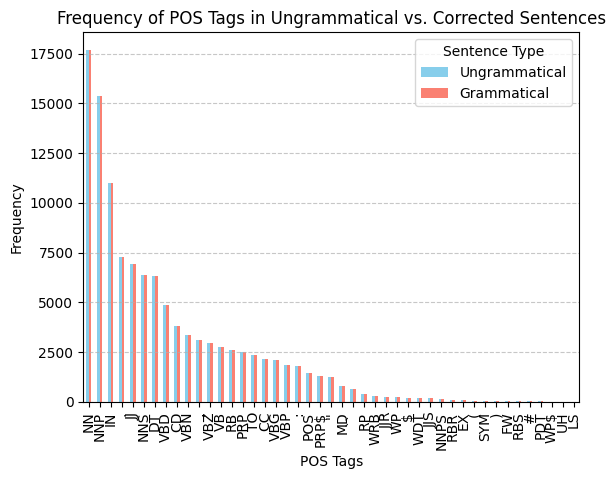

In [26]:
def pos_tag_distributions(sentences: pd.Series, corrections: pd.Series):

    # Method to compute pos tagging on a series of strings
    def pos_tagging(texts):
        tagged_sentences = []
        for sentence in sentences:
            tokens = word_tokenize(sentence)
            tagged = pos_tag(tokens)
            tagged_sentences.extend(tagged)
        return tagged_sentences

    # Compute pos tagging for ungrammatical and grammatical sentences
    pos_tag_ungrammatical = pos_tagging(sentences)
    pos_tag_grammatical = pos_tagging(corrections)

    # Count the frequency of each POS tag
    ungrammatical_pos_counts = pd.Series([tag for _, tag in pos_tag_ungrammatical]).value_counts()
    corrected_pos_counts = pd.Series([tag for _, tag in pos_tag_grammatical]).value_counts()

    # Convert to DataFrame for visualization
    pos_df = pd.DataFrame({
        'Ungrammatical': ungrammatical_pos_counts,
        'Grammatical': corrected_pos_counts
    }).fillna(0)

    # Plot
    plt.figure(figsize=(30, 10))
    pos_df.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Frequency of POS Tags in Ungrammatical vs. Corrected Sentences')
    plt.xlabel('POS Tags')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)  # Rotate the labels vertically
    plt.legend(title='Sentence Type')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

pos_tag_distributions(df["sentence"], df["corrections"])

Error Correction Difficulty Index

In [27]:
import numpy as np
from Levenshtein import distance as levenshtein_distance
import swifter

# Function to generate corrections using T5
def difficulty_index(ungrammatical: str, corrected: str):
    """
    Compute the difficulty index of a corrected sentence compared to an ungrammatical sentence.
    param: ungrammatical: str for ungrammatical sentence
    param: corrected: str for grammatical sentence
    return: float between 0 and 1, where 1 is the most difficult and 0 is the easiest.
    """

    edit_distance = levenshtein_distance(ungrammatical, corrected)
    normalized_distance = edit_distance / max(len(ungrammatical), len(corrected))

    return normalized_distance

# Apply the model to each sentence and store the correction in a new column
df['difficulty_index'] = df.swifter.apply(lambda row: difficulty_index(row['sentence'], row['corrections']), axis=1)
df.head()


Pandas Apply:   0%|          | 0/2000 [00:00<?, ?it/s]

,corrections,sentence,error_type,difficulty_index
272581,2004 BL86 will pass about three times the distance of Earth to the moon. Estimate that the asteroid is about a third of a mile (0.5 kilometers) in size. Nasa says it poses no threat to Earth 'for the foreseeable future',2004 BL86 will pass about three times the distQnSe of Earth to the moon. Estimate that the asteroid is about a third of a mile (0. 5 kilometers) in size. Nasa says it poses no 4Jreat to Earth ' for the foreseeable future ',typo,0.031532
772,"Iraqi Islamic Party calls Quran incident ""blatant assault"" on Muslim holy book. U.S. soldier used Quran for target practice, military investigation found. U.S. commander in Baghdad has issued formal apology. Soldier relieved of duty, will be reassigned after sending letter of apology.","Iraqi Islamic Party calls qran incident "" blatant assault "" on mulism holy book. You. S. soilder used Quran for target pracite, military investigation founf. U. S. commander in Baghdad is issued formal applogy. Soldier relieved of duty, will ne reassigned after seding letter of apology.",spelling error,0.076655
171868,Carroll takes to Instagram to post selfie ahead of ankle surgery. West Ham star expected to be out for up to four months. The forward has had an injury-ravaged spell since moving from Liverpool.,Carroll takes to Instagram post to selfie ahead of surgery ankle. West Ham star expected to be out for up to four months. The forward has had an injury - ravaged spell since moving from Liverpool.,word insertion error,0.102041
63167,"Pop stars from all over Europe are setting their sights on the U.S. market. Estonia's Kerli, Italy's Marco Bosco and Austria's Fawni want to make it big in L.A. Los Angeles has long been a destination for European artists seeking fame.","Pop stars from all over Europe are setting their sights on the U. S. market. Estonia ' s Kerli, Italy ' s Marco Bosco and Austria ' s Fawni want to mZ<e it big in L. A. Los Angeles has p0ng been a destination for European artists seeking fame.",typo,0.049383
68522,"NEW: Young athletes light the Olympic cauldron after the queen opens the games. Performances pay tribute to British history, literature and music. The Greek delegation leads the parade of athletes into the stadium. Organizers had sought beforehand to keep the event's details secret.","NEW: Young athletes light the Olympic cauldron after the queen *)ens the games. Performances pay fdibute to British history, literature and music. The Greek delegation leads the parade of athletes into the stadium. Organizers had sought beforehand to keep the event ' s details secret.",typo,0.021053


In [29]:
import errant
import spacy

annotator = errant.load('en')
nlp = spacy.load("en_core_web_sm")

# Function to get error types using ERRANT
def get_error_types(sentence, correction):
    orig = nlp(sentence)
    cor = nlp(correction)
    
    # Align the original and corrected sentence to detect errors
    alignment = annotator.annotate(orig, cor)
    # Extract the error types (e.g., VERB:TENSE, NOUN:NUM)
    error_types = [error.type for error in alignment]
    return error_types

# Apply the function to each row
df['error'] = df.swifter.apply(lambda row: get_error_types(row['sentence'], row['corrections']), axis=1)
df


Pandas Apply:   0%|          | 0/2000 [00:00<?, ?it/s]

,corrections,sentence,error_type,difficulty_index,error
272581,2004 BL86 will pass about three times the distance of Earth to the moon. Estimate that the asteroid is about a third of a mile (0.5 kilometers) in size. Nasa says it poses no threat to Earth 'for the foreseeable future',2004 BL86 will pass about three times the distQnSe of Earth to the moon. Estimate that the asteroid is about a third of a mile (0. 5 kilometers) in size. Nasa says it poses no 4Jreat to Earth ' for the foreseeable future ',typo,0.031532,"[R:SPELL, R:ORTH, R:NOUN]"
772,"Iraqi Islamic Party calls Quran incident ""blatant assault"" on Muslim holy book. U.S. soldier used Quran for target practice, military investigation found. U.S. commander in Baghdad has issued formal apology. Soldier relieved of duty, will be reassigned after sending letter of apology.","Iraqi Islamic Party calls qran incident "" blatant assault "" on mulism holy book. You. S. soilder used Quran for target pracite, military investigation founf. U. S. commander in Baghdad is issued formal applogy. Soldier relieved of duty, will ne reassigned after seding letter of apology.",spelling error,0.076655,"[R:SPELL, R:SPELL, U:OTHER, R:NOUN, R:SPELL, R:SPELL, R:SPELL, R:ORTH, R:VERB:TENSE, R:SPELL, R:SPELL, R:SPELL]"
171868,Carroll takes to Instagram to post selfie ahead of ankle surgery. West Ham star expected to be out for up to four months. The forward has had an injury-ravaged spell since moving from Liverpool.,Carroll takes to Instagram post to selfie ahead of surgery ankle. West Ham star expected to be out for up to four months. The forward has had an injury - ravaged spell since moving from Liverpool.,word insertion error,0.102041,"[R:WO, R:WO]"
63167,"Pop stars from all over Europe are setting their sights on the U.S. market. Estonia's Kerli, Italy's Marco Bosco and Austria's Fawni want to make it big in L.A. Los Angeles has long been a destination for European artists seeking fame.","Pop stars from all over Europe are setting their sights on the U. S. market. Estonia ' s Kerli, Italy ' s Marco Bosco and Austria ' s Fawni want to mZ<e it big in L. A. Los Angeles has p0ng been a destination for European artists seeking fame.",typo,0.049383,"[R:ORTH, R:NOUN:POSS, U:NOUN:POSS, R:NOUN:POSS, U:VERB, U:NOUN:POSS, R:NOUN:POSS, R:OTHER, R:ORTH, R:ADV]"
68522,"NEW: Young athletes light the Olympic cauldron after the queen opens the games. Performances pay tribute to British history, literature and music. The Greek delegation leads the parade of athletes into the stadium. Organizers had sought beforehand to keep the event's details secret.","NEW: Young athletes light the Olympic cauldron after the queen *)ens the games. Performances pay fdibute to British history, literature and music. The Greek delegation leads the parade of athletes into the stadium. Organizers had sought beforehand to keep the event ' s details secret.",typo,0.021053,"[R:OTHER, R:SPELL, U:NOUN:POSS, R:NOUN:POSS]"
...,...,...,...,...,...
51971,"The minigolf Masters takes place annually at the Hawaiian Rumble course. Czech teenager Olivia Prokopova has won the tournament in each of the last two years. The event was started by Robert Detwiler, founder of the U.S. Pro Minigolf Federation. Some 38,000 registered players compete in tournaments all over the world.","The minigolf Masters takes place annually at the Hawaiian Rumble course. Czech teenager Olivia Prokopova has won the tournament in each of the last 2 years. The event was started by Robert Detwiler, founder of the U. S. Pro Minigolf Federation. Some 38, 000 registered players compete in tournaments all over the world.",word substitution error,0.015674,"[R:OTHER, R:ORTH, R:ORTH]"
169533,"Photos from astronomy contest showcase various night sky sights, with the winning photo from the Alps in Italy. The incredible images range from auroras above a waterfall to the Milky Way glistening over a volcano. The contest has been organised annually since 2009 by the international p

In [34]:
# reverse of explode, groupby sentences and add all the corrections to a list, average the difficulty index column
df_mew = df.groupby(['sentence']).agg({'corrections': lambda x: list(x), 'difficulty_index': 'mean'}).reset_index()
df_mew

,sentence,corrections,difficulty_index
0,""" American Idol "" is doAG to the final contestants. Kree Harrison and Candice Glover wowed the audience. J&Ege Keith Urban "" was really taken with the original songs ""","[""American Idol"" is down to the final contestants. Kree Harrison and Candice Glover wowed the audience. Judge Keith Urban ""was really taken with the original songs""]",0.047904
1,""" Comprehensive "" plan would target "" key vulnerabilities, "" official allege. But U. S. would embody mindful of actions that would harm Iranian people, he says. International coalition is key to keeping pressure up, diplomat says.","[""Comprehensive"" plan would target ""key vulnerabilities,"" official says. But U.S. would be mindful of actions that would harm Iranian people, he says. International coalition is key to keeping pressure up, diplomat says.]",0.069565
2,""" Creative "" is most common buzzword in analysis of one hundred thirty five million LinkedIn profiles. Repeat offenders from last year ' s top 10 list include "" innovative "" and "" motivated "" Banish buzzwords from lexicon and give concrete examples where possible, author say. "" Use language that illustrates your unique professional accomplishments, "" she says.","[""Creative"" is most common buzzword in analysis of 135 million LinkedIn profiles. Repeat offenders from last year's top 10 list include ""innovative"" and ""motivated"" Banish buzzwords from lexicon and give concrete examples where possible, author says. ""Use language that illustrates your unique professional accomplishments,"" she says.]",0.093923
3,""" Doubt "" stars Meryl Streep, Philip Seymour Hoffman, Amy Adams Viola, Davis. Film is based on a Tony Award - and Pulitzer Prize - winning play by the same name. It examines what happens when a nun suspects a priest of abusing a student. Streep advises co - star to pick out a dress for Academy the Awards.","[""Doubt"" stars Meryl Streep, Philip Seymour Hoffman, Amy Adams, Viola Davis. Film is based on a Tony Award- and Pulitzer Prize-winning play by the same name. It examines what happens when a nun suspects a priest of abusing a student. Streep advises co-star to pick out a dress for the Academy Awards.]",0.055556
4,""" Dr. Phil "" has been renewed by stations in 77% percent of the country through the 2016 - 17 season. The show airs on 13 CBS - owned stations, including in the top 5 markets like New York, Los ABgeleq, and Chicago. "" I ' m excited to continue my dynamic partnership with Leslie Moonves and my CBS family, "" Dr. OhiI said.","[""Dr. Phil"" has been renewed by stations in 77% percent of the country through the 2016-17 season. The show airs on 13 CBS-owned stations, including in the top 5 markets like New York, Los Angeles, and Chicago. ""I'm excited to continue my dynamic partnership with Leslie Moonves and my CBS family,"" Dr. Phil said.]",0.043478
...,...,...,...
1995,£ 10million open - air pool will be built in middle of Thames in central London. Water from the river will be pumped lnYo the 82ft by 32ft main lap pool. 4ft - high glass balustrade will protect swimmers from river traffic wavRz.,[£10million open-air pool will be built in middle of Thames in central London. Water from the river will be pumped into the 82ft by 32ft main lap pool. 4ft-high glass balustrade will protect swimmers from river traffic waves.],0.039301
1996,"£ 25, 000 Marcos Mantis was parked under in scaffolding Mayfair It. has been splattered with white paint on the bonnet and windows. The car was also covered in dust and dirt due to nearby roadworks.","[£25,000 Marcos Mantis was parked under scaffolding in Mayfair. It has been splattered with white paint on the bonnet and windows. The car was also covered in dust and dirt due to nearby roadworks.]",0.050505
1997,"£ 600, 000 CT scanner in Bradford hospital first of its kind in the world. Marvel medical of technology makes more scans detailed with less radiation. Designed to accommodate obese patients, taking we

In [ ]:
# compute sentence length, helpful for smart batching
df['sentence_length'] = df['sentence'].str.len()
df = df.sort_values(by='sentence_length')

# Model Corrections

In [ ]:
# reduce df to 100 examples
df_short = df.sample(10)
len(df_short)

"""
different t5 models
google-t5/t5-small
google-t5/t5-base
google-t5/t5-large
google-t5/t5-3b
google-t5/t5-11b
"""

In [ ]:
# add a column namend length to df_short, insert the lenght of sentece
df_short['length'] = df_short['sentence'].str.len()
# sort df_short by length
df_short = df_short.sort_values(by='length')

In [ ]:
%%time
#https://huggingface.co/vennify/t5-base-grammar-correction?library=transformers
# potrebbe non andare bene perchè è stato trainato con jfleg

from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "vennify/t5-base-grammar-correction"

# Load the gpt2 model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Function to generate corrections using GPT2
def t5_corrections(sentences, batch_size):
    corrected_sentences = []
    for i in tqdm(range(0, len(sentences), batch_size)):
        # Take a batch of sentences
        batch = sentences[i:i+batch_size]

        # Prepare the batch input
        input_texts = ["grammar: " + sentence for sentence in batch]
        inputs = tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)

        # Generate corrections for the entire batch
        outputs = model.generate(**inputs, max_length=512, num_beams=4, early_stopping=True)

        # Decode all the generated sentences in the batch
        batch_corrected = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Append the batch results to the final list
        corrected_sentences.extend(batch_corrected)

    return corrected_sentences

# Apply the model to each sentence and store the correction in a new column
df_short['t5_corrections'] = t5_corrections(df_short['sentence'].tolist(), batch_size=16) # ci sta di meno

In [ ]:
pd.set_option('display.max_colwidth', None)
df_short[['sentence', 't5_corrections', 'corrections']]

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm import tqdm

model_id = "mzbac/llama-3-8B-grammar-hf"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Set the pad_token_id explicitly
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)


def llama3_corrections(sentences, batch_size):
    corrected_sentences = []
    
    for i in tqdm(range(0, len(sentences), batch_size)):
        # Take a batch of sentences
        batch = sentences[i:i+batch_size]

        # Prepare inputs for each sentence
        input_texts = [f"Please correct, polish, or translate the text: ```{el}```" for el in batch]

        # Tokenize input sentences
        inputs = tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(model.device)

        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        # Generate responses using the attention mask
        outputs = model.generate(
            input_ids,
            attention_mask=attention_mask,  # Include attention mask
            max_new_tokens=256,
            eos_token_id=tokenizer.eos_token_id,  # Use the correct EOS token
            pad_token_id=tokenizer.pad_token_id,  # Set pad_token_id explicitly
            do_sample=True,
            temperature=0.1,
        )

        # Decode the batch of generated responses
        batch_corrected = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        corrected_sentences.extend(batch_corrected)

    return corrected_sentences

# Apply the model to each sentence and store the correction in a new column
df_short['llama3_correction'] = llama3_corrections(df_short['sentence'].tolist(), batch_size=16)


In [ ]:
df_short[['sentence', 'llama3_correction']]

In [ ]:
%%time

from tqdm import tqdm
import torch
from transformers import BartTokenizer, BartForConditionalGeneration

# Load the bart model and tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')

# try also bart-base

# Function to generate corrections using BART
def bart_correctionions(sentences, batch_size):

    corrected_sentences = []
    for i in tqdm(range(0, len(sentences), batch_size)):
        # Take a batch of sentences
        batch = sentences[i:i+batch_size]

        # Prepare the batch input
        input_texts = ["grammar: " + sentence for sentence in batch]
        inputs = tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)

        # Generate corrections for the entire batch
        outputs = model.generate(**inputs, max_length=512, num_beams=4, early_stopping=True)

        # Decode all the generated sentences in the batch
        batch_corrected = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Append the batch results to the final list
        corrected_sentences.extend(batch_corrected)

    return corrected_sentences

# Apply the model to each sentence and store the correction in a new column
df_short['bart_correction'] = bart_correctionions(df_short['sentence'].tolist(), batch_size=16) # ci sta di meno

In [ ]:
# check also for grammar corrections https://pypi.org/project/language-check/ # also nltk may have tools for grammar correction

In [ ]:
# Display the DataFrame with original and corrected sentences
df_short[['sentence', 't5_corrections']]

In [ ]:
# optimizations https://huggingface.co/docs/transformers/main/en/llm_optims
#speed up
#model.generation_config.cache_implementation = "static" t5 does not support static
#model.forward = torch.compile(model.forward, mode="reduce-overhead", fullgraph=True)


In [ ]:
# try https://huggingface.co/machinelearningzuu/grammar-error-correcter
#https://huggingface.co/imohammad12/GRS-Grammar-Checker-DeBerta